# Experiment: MSFT 1-Minute GRU Recursive Forecast (PRD)

Objective:
- Train a PyTorch GRU on MSFT 1-minute OHLC candles from Alpaca (target: last 60 days).
- Use 500-candle windows to predict the next candle.
- Recursively forecast 15 future candles from one seed window.
- Visualize predicted candles in the requested color style.

Success criteria:
- Notebook runs top-to-bottom and reports one-step and recursive metrics.
- Final chart clearly distinguishes history (green/red) vs predictions (white/black).


In [1]:
# Optional dependency bootstrap (kept lightweight).
import importlib.util
import subprocess
import sys

required = {
    'alpaca': 'alpaca-py',
    'numpy': 'numpy',
    'pandas': 'pandas',
    'matplotlib': 'matplotlib',
    'sklearn': 'scikit-learn',
}

missing = [pkg for module_name, pkg in required.items() if importlib.util.find_spec(module_name) is None]
if missing:
    print('Installing missing packages:', missing)
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q', *missing])
else:
    print('All required third-party packages are already installed.')

print('If torch is missing, install it separately with a CUDA wheel suitable for your RTX 3070 and driver.')


All required third-party packages are already installed.
If torch is missing, install it separately with a CUDA wheel suitable for your RTX 3070 and driver.


In [2]:
# Setup: imports and reproducibility
from __future__ import annotations

import os
import random
import time
from datetime import datetime, timedelta, timezone

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from alpaca.data.enums import DataFeed
from alpaca.data.historical import StockHistoricalDataClient
from alpaca.data.requests import StockBarsRequest
from alpaca.data.timeframe import TimeFrame
from IPython.display import display
from matplotlib import pyplot as plt
from matplotlib.patches import Patch, Rectangle
from sklearn.metrics import mean_absolute_error, mean_squared_error
from torch.utils.data import DataLoader, Dataset

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

torch.backends.cudnn.benchmark = True
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f'Using device: {DEVICE}')
if torch.cuda.is_available():
    print('GPU:', torch.cuda.get_device_name(0))
    print('CUDA:', torch.version.cuda)


Using device: cuda
GPU: NVIDIA GeForce RTX 3070
CUDA: 12.1


## Plan

- Data: download MSFT 1-minute OHLC candles over 60 days from Alpaca.
- Free-plan safety: throttle requests to 120/min (below Alpaca basic limit of 200/min).
- Features: raw OHLC only (no indicators).
- Model: 2-layer GRU (hidden=128, dropout=0.2) -> linear head to next OHLC.
- Training: time-aware split, train-only normalization, MSE loss, Adam, early stopping.
- Inference: recursive 15-step forecast using own predictions as future inputs.
- Visualization: history as green/red, predicted as white/black.


In [3]:
# Experiment configuration
SYMBOL = 'MSFT'
LOOKBACK_DAYS = 60
FEATURES = ['Open', 'High', 'Low', 'Close']

WINDOW = 500
HORIZON = 15

TRAIN_RATIO = 0.70
VAL_RATIO = 0.15

BATCH_SIZE = 256
HIDDEN_SIZE = 128
NUM_LAYERS = 2
DROPOUT = 0.2
LEARNING_RATE = 1e-3
EPOCHS = 12
PATIENCE = 3

# Alpaca config
ALPACA_FEED = os.getenv('ALPACA_FEED', 'iex').strip().lower()  # free-plan safe default
REQUEST_CHUNK_DAYS = 5
MAX_REQUESTS_PER_MINUTE = 120  # below free-plan 200/min cap
MAX_RETRIES = 5

print({
    'symbol': SYMBOL,
    'lookback_days': LOOKBACK_DAYS,
    'window': WINDOW,
    'horizon': HORIZON,
    'alpaca_feed': ALPACA_FEED,
    'request_chunk_days': REQUEST_CHUNK_DAYS,
    'max_requests_per_minute': MAX_REQUESTS_PER_MINUTE,
    'device': str(DEVICE),
})


{'symbol': 'MSFT', 'lookback_days': 60, 'window': 500, 'horizon': 15, 'alpaca_feed': 'iex', 'request_chunk_days': 5, 'max_requests_per_minute': 120, 'device': 'cuda'}


In [4]:
# Data download and cleaning (Alpaca)
class RequestPacer:
    def __init__(self, max_calls_per_minute: int):
        if max_calls_per_minute <= 0:
            raise ValueError('max_calls_per_minute must be > 0')
        self.min_interval = 60.0 / float(max_calls_per_minute)
        self.last_call_ts = 0.0

    def wait(self) -> None:
        now = time.monotonic()
        elapsed = now - self.last_call_ts
        if elapsed < self.min_interval:
            time.sleep(self.min_interval - elapsed)
        self.last_call_ts = time.monotonic()


def _require_alpaca_credentials() -> tuple[str, str]:
    api_key = os.getenv('ALPACA_API_KEY')
    secret_key = os.getenv('ALPACA_SECRET_KEY')
    if not api_key or not secret_key:
        raise RuntimeError(
            'Missing Alpaca credentials. Set ALPACA_API_KEY and ALPACA_SECRET_KEY before running this notebook.'
        )
    return api_key, secret_key


def _resolve_feed(feed_name: str) -> DataFeed:
    mapping = {
        'iex': DataFeed.IEX,
        'sip': DataFeed.SIP,
        'delayed_sip': DataFeed.DELAYED_SIP,
    }
    key = feed_name.strip().lower()
    if key not in mapping:
        raise ValueError(f'Unsupported ALPACA_FEED={feed_name!r}. Use one of: {list(mapping)}')
    return mapping[key]


def fetch_ohlc_1m_alpaca(
    symbol: str,
    lookback_days: int,
    feed_name: str,
    chunk_days: int,
    max_calls_per_minute: int,
    max_retries: int = 5,
) -> tuple[pd.DataFrame, int]:
    api_key, secret_key = _require_alpaca_credentials()
    client = StockHistoricalDataClient(api_key=api_key, secret_key=secret_key)

    feed = _resolve_feed(feed_name)
    pacer = RequestPacer(max_calls_per_minute=max_calls_per_minute)

    end_ts = datetime.now(timezone.utc).replace(second=0, microsecond=0)
    # Conservative offset for free/basic access when using SIP-based feeds.
    if feed_name in {'sip', 'delayed_sip'}:
        end_ts = end_ts - timedelta(minutes=20)

    start_ts = end_ts - timedelta(days=lookback_days)

    frames: list[pd.DataFrame] = []
    cursor = start_ts
    api_call_count = 0

    while cursor < end_ts:
        chunk_end = min(cursor + timedelta(days=chunk_days), end_ts)
        bars = None

        for attempt in range(1, max_retries + 1):
            pacer.wait()
            api_call_count += 1
            try:
                req = StockBarsRequest(
                    symbol_or_symbols=[symbol],
                    timeframe=TimeFrame.Minute,
                    start=cursor,
                    end=chunk_end,
                    feed=feed,
                    limit=10_000,
                )
                bars = client.get_stock_bars(req).df
                break
            except Exception as exc:
                msg = str(exc).lower()
                if ('429' in msg or 'rate limit' in msg) and attempt < max_retries:
                    backoff = min(2 ** attempt, 30)
                    print(f'Rate limit response on chunk {cursor} -> {chunk_end}; sleeping {backoff}s (attempt {attempt}/{max_retries}).')
                    time.sleep(backoff)
                    continue

                if ('subscription' in msg or 'forbidden' in msg) and feed_name != 'iex':
                    raise RuntimeError(
                        f'Feed {feed_name!r} is not available for this account. Use ALPACA_FEED=iex for free-plan compatibility.'
                    ) from exc

                raise

        if bars is not None and not bars.empty:
            chunk_df = bars.reset_index()
            chunk_df = chunk_df.rename(
                columns={
                    'timestamp': 'Datetime',
                    'open': 'Open',
                    'high': 'High',
                    'low': 'Low',
                    'close': 'Close',
                }
            )

            needed = ['Datetime', 'Open', 'High', 'Low', 'Close']
            missing = [c for c in needed if c not in chunk_df.columns]
            if missing:
                raise RuntimeError(f'Alpaca response missing required columns: {missing}')

            chunk_df['Datetime'] = pd.to_datetime(chunk_df['Datetime'], utc=True).dt.tz_convert(None)
            chunk_df = chunk_df[needed].dropna().set_index('Datetime').sort_index()
            frames.append(chunk_df)

        cursor = chunk_end

    if not frames:
        raise RuntimeError('No bars returned from Alpaca. Verify symbol, credentials, feed, and market session.')

    df = pd.concat(frames, axis=0).sort_index()
    df = df[~df.index.duplicated(keep='last')]
    df = df.dropna(subset=FEATURES)

    return df.astype(np.float32), api_call_count


raw_df, api_calls = fetch_ohlc_1m_alpaca(
    symbol=SYMBOL,
    lookback_days=LOOKBACK_DAYS,
    feed_name=ALPACA_FEED,
    chunk_days=REQUEST_CHUNK_DAYS,
    max_calls_per_minute=MAX_REQUESTS_PER_MINUTE,
    max_retries=MAX_RETRIES,
)

span_days = (raw_df.index.max() - raw_df.index.min()).total_seconds() / 86400
print(f'Rows: {len(raw_df):,}')
print(f'Time span in returned data: {span_days:.1f} days')
print(f'Alpaca API calls made: {api_calls} (throttled to <= {MAX_REQUESTS_PER_MINUTE} requests/min)')
if span_days < LOOKBACK_DAYS * 0.9:
    print('Warning: Returned span is shorter than 60 days. This can happen due to feed/session constraints.')

min_needed = WINDOW + HORIZON + 200
if len(raw_df) < min_needed:
    raise RuntimeError(f'Not enough rows ({len(raw_df)}) for window={WINDOW} and horizon={HORIZON}. Need at least {min_needed}.')

raw_df.tail()


Rows: 15,082
Time span in returned data: 59.3 days
Alpaca API calls made: 12 (throttled to <= 120 requests/min)


,Open,High,Low,Close
Datetime,,,,
2026-02-09 20:56:00,413.760010,413.799988,413.320007,413.489990
2026-02-09 20:57:00,413.480011,414.130005,413.399994,414.049988
2026-02-09 20:58:00,414.029999,414.179993,414.029999,414.109985
2026-02-09 20:59:00,414.065002,414.149994,413.559998,413.690002
2026-02-09 21:11:00,413.450012,413.450012,413.450012,413.450012


In [5]:
# Build sequences with train/val/test time split and train-only normalization
def split_indices(n_rows: int, train_ratio: float, val_ratio: float) -> tuple[int, int]:
    train_end = int(n_rows * train_ratio)
    val_end = int(n_rows * (train_ratio + val_ratio))
    return train_end, val_end


def make_windows(values: np.ndarray, window: int) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    X, y, target_idx = [], [], []
    for i in range(window, len(values)):
        X.append(values[i - window : i])
        y.append(values[i])
        target_idx.append(i)

    return (
        np.asarray(X, dtype=np.float32),
        np.asarray(y, dtype=np.float32),
        np.asarray(target_idx, dtype=np.int64),
    )


class SequenceDataset(Dataset):
    def __init__(self, X: np.ndarray, y: np.ndarray):
        self.X = torch.from_numpy(X).float()
        self.y = torch.from_numpy(y).float()

    def __len__(self) -> int:
        return len(self.X)

    def __getitem__(self, idx: int):
        return self.X[idx], self.y[idx]


raw_values = raw_df[FEATURES].to_numpy(dtype=np.float32)
train_end, val_end = split_indices(len(raw_df), TRAIN_RATIO, VAL_RATIO)

train_mean = raw_values[:train_end].mean(axis=0)
train_std = raw_values[:train_end].std(axis=0)
train_std = np.where(train_std < 1e-8, 1.0, train_std)

scaled_values = (raw_values - train_mean) / train_std

X_all, y_all, seq_idx = make_windows(scaled_values, WINDOW)

train_mask = seq_idx < train_end
val_mask = (seq_idx >= train_end) & (seq_idx < val_end)
test_mask = seq_idx >= val_end

X_train, y_train = X_all[train_mask], y_all[train_mask]
X_val, y_val = X_all[val_mask], y_all[val_mask]
X_test, y_test = X_all[test_mask], y_all[test_mask]

train_loader = DataLoader(SequenceDataset(X_train, y_train), batch_size=BATCH_SIZE, shuffle=True, drop_last=False)
val_loader = DataLoader(SequenceDataset(X_val, y_val), batch_size=BATCH_SIZE, shuffle=False, drop_last=False)
test_loader = DataLoader(SequenceDataset(X_test, y_test), batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

print('Split rows:', {'train': train_end, 'val': val_end - train_end, 'test': len(raw_df) - val_end})
print('Windowed samples:', {'train': len(X_train), 'val': len(X_val), 'test': len(X_test)})
print('X_train shape:', X_train.shape, 'y_train shape:', y_train.shape)
if len(X_train) == 0 or len(X_val) == 0 or len(X_test) == 0:
    raise RuntimeError('One or more splits are empty. Increase data range or adjust split ratios.')



Split rows: {'train': 10557, 'val': 2262, 'test': 2263}
Windowed samples: {'train': 10057, 'val': 2262, 'test': 2263}
X_train shape: (10057, 500, 4) y_train shape: (10057, 4)


In [6]:
# GRU model + training loop
class GRUForecaster(nn.Module):
    def __init__(self, input_size: int = 4, hidden_size: int = 128, num_layers: int = 2, dropout: float = 0.2):
        super().__init__()
        self.gru = nn.GRU(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0,
        )
        self.head = nn.Linear(hidden_size, input_size)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        out, _ = self.gru(x)
        return self.head(out[:, -1, :])


def run_epoch(model: nn.Module, loader: DataLoader, loss_fn: nn.Module, optimizer: torch.optim.Optimizer | None = None) -> float:
    is_train = optimizer is not None
    model.train(is_train)

    total_loss = 0.0
    total_items = 0

    for xb, yb in loader:
        xb = xb.to(DEVICE)
        yb = yb.to(DEVICE)

        if is_train:
            optimizer.zero_grad(set_to_none=True)

        with torch.set_grad_enabled(is_train):
            pred = model(xb)
            loss = loss_fn(pred, yb)

        if is_train:
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

        batch_size = xb.size(0)
        total_loss += loss.item() * batch_size
        total_items += batch_size

    return total_loss / max(total_items, 1)


def train_model(model: nn.Module, train_loader: DataLoader, val_loader: DataLoader, epochs: int, lr: float, patience: int):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    best_val = float('inf')
    best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
    wait = 0
    history = []

    for epoch in range(1, epochs + 1):
        train_loss = run_epoch(model, train_loader, loss_fn, optimizer)
        val_loss = run_epoch(model, val_loader, loss_fn, optimizer=None)

        history.append({'epoch': epoch, 'train_loss': train_loss, 'val_loss': val_loss})
        print(f'Epoch {epoch:02d} | train_loss={train_loss:.6f} | val_loss={val_loss:.6f}')

        if val_loss < best_val:
            best_val = val_loss
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                print(f'Early stopping at epoch {epoch}.')
                break

    model.load_state_dict(best_state)
    return history


Epoch 01 | train_loss=0.145840 | val_loss=0.630812
Epoch 02 | train_loss=0.007303 | val_loss=0.343793
Epoch 03 | train_loss=0.003502 | val_loss=0.221317
Epoch 04 | train_loss=0.002353 | val_loss=0.161044
Epoch 05 | train_loss=0.002045 | val_loss=0.134189
Epoch 06 | train_loss=0.001975 | val_loss=0.127870
Epoch 07 | train_loss=0.001876 | val_loss=0.107519
Epoch 08 | train_loss=0.001765 | val_loss=0.111521
Epoch 09 | train_loss=0.001661 | val_loss=0.089016
Epoch 10 | train_loss=0.001655 | val_loss=0.089691
Epoch 11 | train_loss=0.001609 | val_loss=0.083034
Epoch 12 | train_loss=0.001568 | val_loss=0.080043


,epoch,train_loss,val_loss
7,8,0.001765,0.111521
8,9,0.001661,0.089016
9,10,0.001655,0.089691
10,11,0.001609,0.083034
11,12,0.001568,0.080043


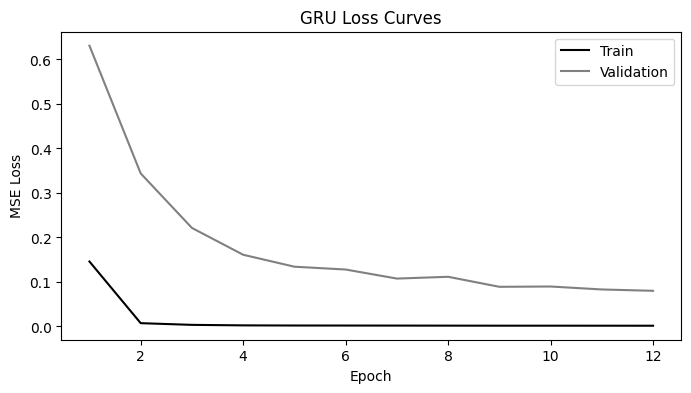

In [7]:
# Train
model = GRUForecaster(
    input_size=len(FEATURES),
    hidden_size=HIDDEN_SIZE,
    num_layers=NUM_LAYERS,
    dropout=DROPOUT,
).to(DEVICE)

history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=EPOCHS,
    lr=LEARNING_RATE,
    patience=PATIENCE,
)

history_df = pd.DataFrame(history)
display(history_df.tail())

plt.figure(figsize=(8, 4))
plt.plot(history_df['epoch'], history_df['train_loss'], label='Train', color='black')
plt.plot(history_df['epoch'], history_df['val_loss'], label='Validation', color='gray')
plt.title('GRU Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()


In [9]:
# One-step evaluation on test set
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader
from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error

def inverse_scale(arr: np.ndarray, mean: np.ndarray, std: np.ndarray) -> np.ndarray:
    return arr * std + mean


@torch.no_grad()
def collect_preds(model: nn.Module, loader: DataLoader) -> tuple[np.ndarray, np.ndarray]:
    model.eval()
    preds, targets = [], []

    for xb, yb in loader:
        xb = xb.to(DEVICE)
        yhat = model(xb).cpu().numpy()
        preds.append(yhat)
        targets.append(yb.numpy())

    return np.vstack(preds), np.vstack(targets)


pred_test_scaled, y_test_scaled = collect_preds(model, test_loader)
pred_test = inverse_scale(pred_test_scaled, train_mean, train_std)
y_test_raw = inverse_scale(y_test_scaled, train_mean, train_std)

test_target_indices = seq_idx[test_mask]
prev_close = raw_values[test_target_indices - 1, 3]
actual_close = y_test_raw[:, 3]
pred_close = pred_test[:, 3]

close_mae = mean_absolute_error(actual_close, pred_close)
close_rmse = root_mean_squared_error(actual_close, pred_close)

# OHLC metrics across all 4 outputs (uniform average across columns by default)
ohlc_mae = mean_absolute_error(y_test_raw, pred_test)
ohlc_rmse = root_mean_squared_error(y_test_raw, pred_test)

dir_acc = np.mean(np.sign(actual_close - prev_close) == np.sign(pred_close - prev_close))

one_step_metrics = {
    "close_mae": float(close_mae),
    "close_rmse": float(close_rmse),
    "ohlc_mae": float(ohlc_mae),
    "ohlc_rmse": float(ohlc_rmse),
    "directional_accuracy": float(dir_acc),
}

print("One-step test metrics:")
for k, v in one_step_metrics.items():
    print(f"  {k}: {v:.6f}")


One-step test metrics:
  close_mae: 19.295929
  close_rmse: 20.784559
  ohlc_mae: 19.157749
  ohlc_rmse: 20.655048
  directional_accuracy: 0.485197


In [11]:
# Recursive 15-step forecast
import numpy as np
import pandas as pd
import torch
from torch import nn
from sklearn.metrics import mean_absolute_error, root_mean_squared_error

@torch.no_grad()
def recursive_forecast(model: nn.Module, seed_window_scaled: np.ndarray, horizon: int) -> np.ndarray:
    model.eval()
    window = seed_window_scaled.copy()
    preds = []

    for _ in range(horizon):
        x = torch.from_numpy(window).float().unsqueeze(0).to(DEVICE)  # (1, WINDOW, n_features)
        next_step = model(x).cpu().numpy()[0]                         # (n_features,)
        preds.append(next_step)
        window = np.vstack([window[1:], next_step])

    return np.asarray(preds, dtype=np.float32)


anchor_end = len(raw_df) - HORIZON - 1
if anchor_end - WINDOW + 1 < 0:
    raise RuntimeError("Not enough rows for recursive seed window.")

seed_scaled = scaled_values[anchor_end - WINDOW + 1 : anchor_end + 1]
recursive_scaled = recursive_forecast(model, seed_scaled, HORIZON)
recursive_pred = inverse_scale(recursive_scaled, train_mean, train_std)

future_actual = raw_values[anchor_end + 1 : anchor_end + 1 + HORIZON]
future_index = raw_df.index[anchor_end + 1 : anchor_end + 1 + HORIZON]

pred_future_df = pd.DataFrame(recursive_pred, index=future_index, columns=FEATURES)
actual_future_df = pd.DataFrame(future_actual, index=future_index, columns=FEATURES)

recursive_close_mae = mean_absolute_error(actual_future_df["Close"], pred_future_df["Close"])
recursive_close_rmse = root_mean_squared_error(actual_future_df["Close"], pred_future_df["Close"])

print("Recursive 15-step metrics (close):")
print(f"  mae:  {recursive_close_mae:.6f}")
print(f"  rmse: {recursive_close_rmse:.6f}")

display(pd.concat(
    {
        "actual_close": actual_future_df["Close"],
        "pred_close": pred_future_df["Close"],
    },
    axis=1,
))

Recursive 15-step metrics (close):
  mae:  18.652132
  rmse: 18.731033


,actual_close,pred_close
Datetime,,
2026-02-09 20:46:00,413.839996,429.123535
2026-02-09 20:47:00,414.125000,429.903839
2026-02-09 20:48:00,414.119995,430.703888
2026-02-09 20:49:00,414.269989,431.346954
2026-02-09 20:50:00,414.019989,431.868164
2026-02-09 20:51:00,414.005005,432.300110
2026-02-09 20:52:00,413.670013,432.666321
2026-02-09 20:53:00,413.470001,432.982819
2026-02-09 20:54:00,414.299988,433.259674


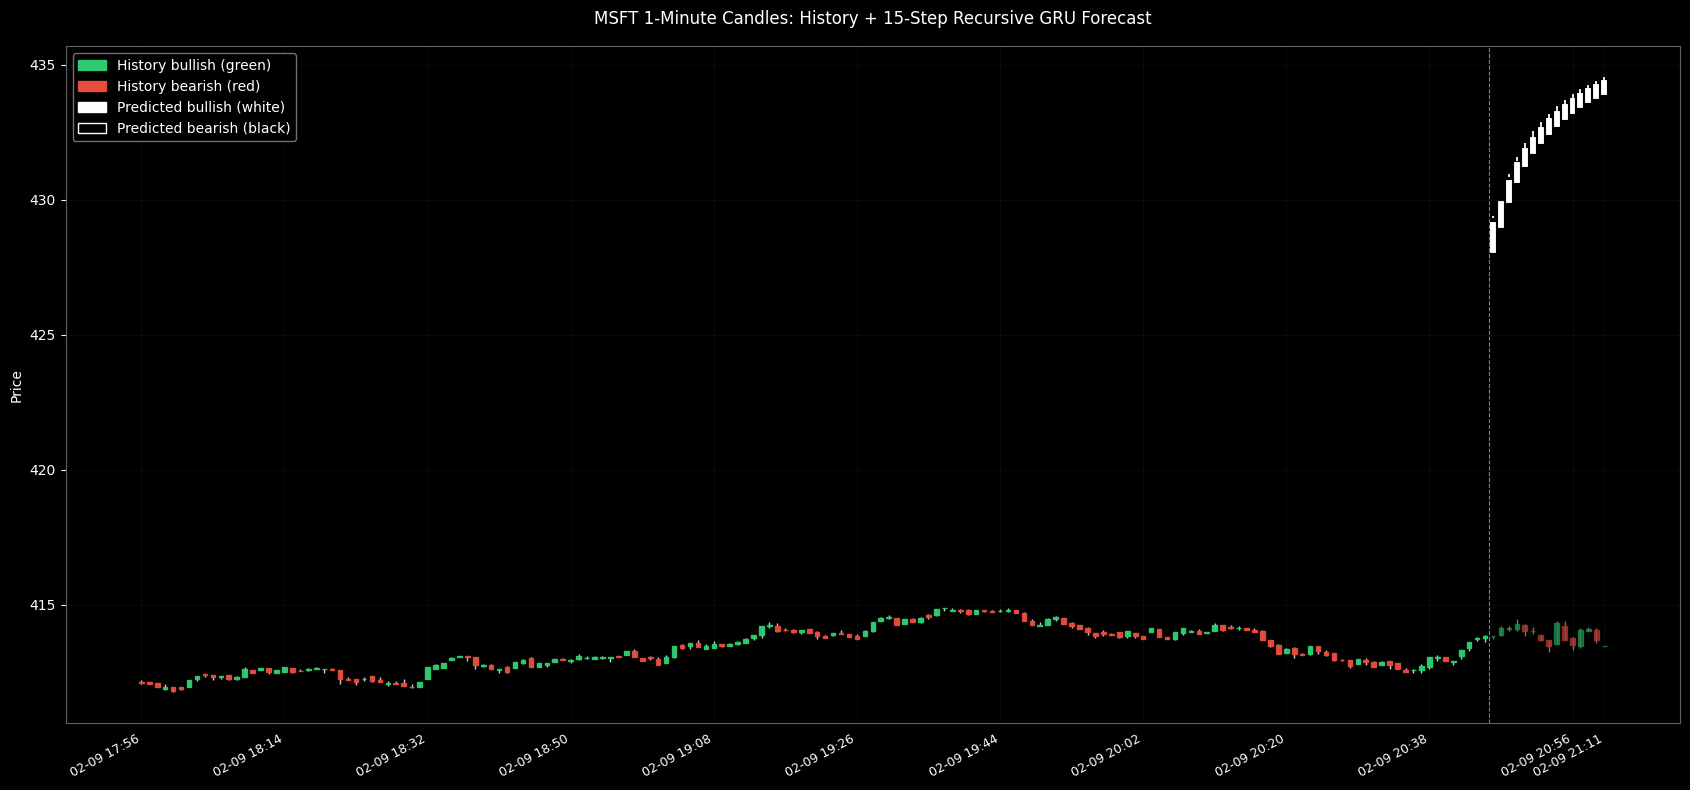

In [12]:
# Candlestick rendering with requested color mapping
# - History: green (bullish) / red (bearish)
# - Predicted: white (bullish) / black (bearish)
def draw_candles(
    ax,
    ohlc: pd.DataFrame,
    start_x: int,
    up_edge: str,
    up_face: str,
    down_edge: str,
    down_face: str,
    wick_color: str,
    width: float = 0.62,
    lw: float = 1.0,
    alpha: float = 1.0,
):
    values = ohlc[['Open', 'High', 'Low', 'Close']].to_numpy()

    for i, (o, h, l, c) in enumerate(values):
        x = start_x + i
        bullish = c >= o

        ax.vlines(x, l, h, color=wick_color, linewidth=lw, alpha=alpha, zorder=2)

        lower = min(o, c)
        height = abs(c - o)
        if height < 1e-8:
            height = 1e-6

        face = up_face if bullish else down_face
        edge = up_edge if bullish else down_edge

        rect = Rectangle(
            (x - width / 2, lower),
            width,
            height,
            facecolor=face,
            edgecolor=edge,
            linewidth=lw,
            alpha=alpha,
            zorder=3,
        )
        ax.add_patch(rect)


context_bars = 170
context_start = max(0, anchor_end - context_bars + 1)
context_df = raw_df.iloc[context_start : anchor_end + 1][FEATURES].copy()

fig, ax = plt.subplots(figsize=(17, 8), facecolor='black')
ax.set_facecolor('black')

# Historical candles (actual): green/red
draw_candles(
    ax,
    context_df,
    start_x=0,
    up_edge='#2ECC71',
    up_face='#2ECC71',
    down_edge='#E74C3C',
    down_face='#E74C3C',
    wick_color='#D9D9D9',
    width=0.58,
    lw=1.0,
    alpha=0.95,
)

# Actual future candles (for comparison): muted green/red
draw_candles(
    ax,
    actual_future_df,
    start_x=len(context_df),
    up_edge='#1E8F4E',
    up_face='#1E8F4E',
    down_edge='#B03A2E',
    down_face='#B03A2E',
    wick_color='#9A9A9A',
    width=0.58,
    lw=1.0,
    alpha=0.75,
)

# Predicted future candles: white if bullish (green-equivalent), black if bearish (red-equivalent)
draw_candles(
    ax,
    pred_future_df,
    start_x=len(context_df),
    up_edge='#FFFFFF',
    up_face='#FFFFFF',
    down_edge='#000000',
    down_face='#000000',
    wick_color='#F0F0F0',
    width=0.50,
    lw=1.35,
    alpha=1.0,
)

split_x = len(context_df) - 0.5
ax.axvline(split_x, color='white', linestyle='--', linewidth=0.8, alpha=0.5)

combined_index = context_df.index.append(actual_future_df.index)
total_bars = len(combined_index)
tick_step = max(1, total_bars // 10)
ticks = list(range(0, total_bars, tick_step))
if ticks[-1] != total_bars - 1:
    ticks.append(total_bars - 1)

labels = [combined_index[i].strftime('%m-%d %H:%M') for i in ticks]
ax.set_xticks(ticks)
ax.set_xticklabels(labels, rotation=28, ha='right', color='white', fontsize=9)

ax.tick_params(axis='y', colors='white')
for spine in ax.spines.values():
    spine.set_color('#606060')

ax.grid(color='#222222', linewidth=0.6, alpha=0.35)
ax.set_title('MSFT 1-Minute Candles: History + 15-Step Recursive GRU Forecast', color='white', pad=16)
ax.set_ylabel('Price', color='white')

legend_elements = [
    Patch(facecolor='#2ECC71', edgecolor='#2ECC71', label='History bullish (green)'),
    Patch(facecolor='#E74C3C', edgecolor='#E74C3C', label='History bearish (red)'),
    Patch(facecolor='#FFFFFF', edgecolor='#FFFFFF', label='Predicted bullish (white)'),
    Patch(facecolor='#000000', edgecolor='#FFFFFF', label='Predicted bearish (black)'),
]
leg = ax.legend(handles=legend_elements, facecolor='black', edgecolor='#707070', framealpha=1.0, loc='upper left')
for text in leg.get_texts():
    text.set_color('white')

plt.tight_layout()
plt.show()


## Results

- `one_step_metrics` reports t+1 quality over the test split.
- `recursive_close_mae/rmse` report 15-step recursive error accumulation.
- Final chart uses requested style: history green/red and predicted candles white/black.

## Next steps

- If your account/feed allows, compare `ALPACA_FEED=iex` vs `ALPACA_FEED=delayed_sip` quality.
- Add walk-forward evaluation windows.
- After baseline lock-in, extend to multi-symbol training and then crypto.
